# Demo for Learning Rate Decay Application

This demo will address how to make use of the learning rate scheduler in the context of a segmentation task. The scheduler allows for the learning rate to evolve predictably with training iterations (this will typically be a decay over time). This demo assumes you have a working installation of NiftyNet.

## Preparation:

1) Ensure you are in the NiftyNet root, and set this root as an environment variable:

In [ ]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
niftynet_path='your/niftynet/path'  # Set your NiftyNet root path here
os.environ['niftynet_config_home'] = niftynet_path
os.chdir(niftynet_path)

2) Acquire the data. We will make use of a publicly available hippocampus segmentation dataset in this demo. Prior to this you will need to create a file named 'config.ini' in your NiftyNet root folder with the following format:

```ini
[global]
home = /your/niftynet/path
```

The following code snippet will create the file for you:

In [ ]:
f = open("config.ini", "w+")
f.write("[global]\n")
f.write("home = {}".format(niftynet_path))
f.close()

Now you are ready to download the data which you can do by running the following cell:

In [ ]:
%run net_download.py decathlon_hippocampus -r

The training data, labels, and test data will be downloaded into the */data/decathlon_hippocampus/* folder in your NiftyNet root directory.

## The configuration file:

The configuration file in NiftyNet specifies all the parameters pertinent to the training/ inference task at hand including but not limited to: Training data location, network of choice, learning rate, etc. <br>

In this instance a configuration file has been provided (learning_rate_demo_train_config.ini) with default settings for a segmentation training task. Note that these settings can be overriden in the command line or by simply editing the configuration file. For further information regarding the configuration file and the individual variables refer to the relevant documentation [here](https://niftynet.readthedocs.io/en/latest/config_spec.html).

## Training a network from the command line:

To run this application from the command line using the variables specified in the configuration file:

```python net_run.py train -a niftynet.contrib.learning_rate_schedule.decay_lr_application.DecayLearningRateApplication 
                        -c /demos/Learning_Rate_Decay/learning_rate_demo_train_config.ini --max_iter 90```

With the current setup, the learning rate will halve every three iterations. NiftyNet will create *logs* and *models* folders to store training logs and models, respectively. <br>

The following cells exemplify the potential benefit of having a decaying learning rate: Two networks are trained, one lacks any learning rate scheduling, the other has a learning rate schedule that decays the learning rate by 2% every 5 iterations. By looking at the loss curves we can see that the latter converges towards a lower cross entropy despite the exact same initialisation:

In [ ]:
import os
import sys
import niftynet
sys.argv=['','train','-a','demos.Learning_Rate_Decay.Demo_applications.decay_lr_comparison_application.DecayLearningRateApplication','-c',os.path.join('demos','Learning_Rate_Decay','learning_rate_demo_train_config.ini'),'--max_iter','500','--lr','25.0','--model_dir','./models/decay']
niftynet.main()
sys.argv=['','train','-a','demos.Learning_Rate_Decay.Demo_applications.no_decay_lr_comparison_application.DecayLearningRateApplication','-c',os.path.join('demos','Learning_Rate_Decay','learning_rate_demo_train_config.ini'),'--max_iter','500','--lr','25.0','--model_dir','./models/no_decay']
niftynet.main()

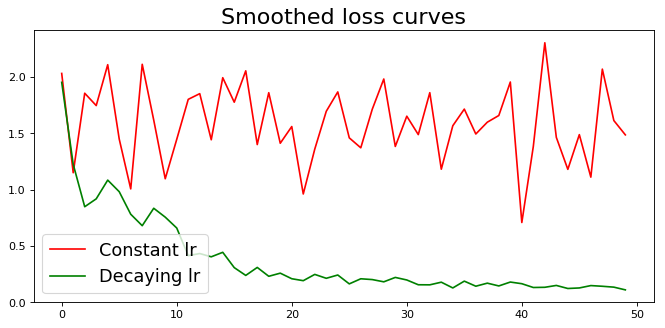

In [19]:
decay_model_dir = niftynet_path + '/models/decay'
no_decay_model_dir = niftynet_path + '/models/no_decay'

with open(os.path.join(decay_model_dir, 'training_niftynet_log'), 'r') as f:
    lines = f.readlines()
    data = ' '.join(lines)
    last_run = data.rpartition('Parameters from random initialisations')[-1]
    last_run_lines = last_run.split('\n')
    raw_lines = [l.split(',')[1:] for l in last_run_lines if 'loss' in l]
    iterations = [int(l[0].split(':')[1].split(' ')[-1]) for l in raw_lines]
    decay_CE_losses = [float(l[1].split('=')[1]) for l in raw_lines]

with open(os.path.join(no_decay_model_dir, 'training_niftynet_log'), 'r') as f:
    lines = f.readlines()
    data = ' '.join(lines)
    last_run = data.rpartition('Parameters from random initialisations')[-1]
    last_run_lines = last_run.split('\n')
    raw_lines = [l.split(',')[1:] for l in last_run_lines if 'loss' in l]
    iterations = [int(l[0].split(':')[1].split(' ')[-1]) for l in raw_lines]
    no_decay_CE_losses = [float(l[1].split('=')[1]) for l in raw_lines]

fig = plt.figure(figsize=(10, 4.5), dpi=80)
plt.plot([np.mean(no_decay_CE_losses[l:l+10]) for l in range(0,len(no_decay_CE_losses), 10)],
         color='red', label='Constant lr')
plt.plot([np.mean(decay_CE_losses[l:l+10]) for l in range(0,len(decay_CE_losses), 10)],
         color='green', label='Decaying lr')
plt.title("Smoothed loss curves", fontsize=20)
plt.legend(fontsize=16)
plt.show()

## Customising the learning rate scheduler:

Currently the application is set up such that the learning rate is halved every third training iteration. This is an arbitrary default setup and it is likely you'll want to alter this to suit your purposes. Let's look at the *set_iteration_update* method of the *DecayLearningRateApplication* class in the application (*decay_lr_application.py*):

In [ ]:
def set_iteration_update(self, iteration_message):
    """
    This function will be called by the application engine at each
    iteration.
    """
    current_iter = iteration_message.current_iter
    if iteration_message.is_training:
        if current_iter > 0 and current_iter % 3 == 0:
            self.current_lr = self.current_lr / 2.0
        iteration_message.data_feed_dict[self.is_validation] = False
    elif iteration_message.is_validation:
        iteration_message.data_feed_dict[self.is_validation] = True
    iteration_message.data_feed_dict[self.learning_rate] = self.current_lr

The relevant subsection we will want to focus on is contained in two lines:

In [ ]:
if current_iter > 0 and current_iter % 3 == 0:
    self.current_lr = self.current_lr / 2.0

The second line contains the logic that changes the learning rate wheras the first line stipulates the condition under which this will occur. As such only these two lines need to be changed if the scheduling is to be changed. For example, if we'd like to reduce the learning rate by 1% every 5 iterations then this snippet of code would look like:

In [ ]:
if current_iter > 0 and current_iter % 5 == 0:
    self.current_lr = self.current_lr * 0.99

Similarly, if we'd like for the learning rate to decay exponentially every iteration modulated by some factor *k*:

In [ ]:
if current_iter > 0:
    self.current_lr = self.current_lr * np.exp(-k * current_iter)

## Summary:

In this demo we have covered the following: <br>
1. How to run NiftyNet using the learning rate decay application from the command line and from python code directly
2. How to edit the learning rate application to schedule the learning rate to suit one's needs